# Bitcoin prediction - Artificial Intelligence Exam Summer 2019
## Time series prediction using:
* Autoregressive Integrated Moving Average (ARIMA)
* Recurrent Neural Networks and Long-Short Term Memory

Bitcoin is the largest cryptocurrency in the world. It is a digital currency without need of a central bank or administrator. It is purely based off the peer-to-peer network. Since 2013 the Bitcoin price has been doubled by a 1000. The price is now around 9000 USD.

In this notebook we will investigate wether it is possible to predict future Bitcoin prices based on time series data.
The dataset is from [CryptoCompare](https://www.cryptocompare.com/).



In [13]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
from math import sqrt
import statsmodels.api as sm
from datetime import datetime
import requests
import json

# Pandas - data analysis library.
import pandas as pd
from pandas import Series

# Sklearn - supervised and unsupervised learning algorithm library.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Keras - neural-network library running on top of Tensorflow.
from keras.models import Sequential
from keras.layers import Dense
#from keras.layers import Flatten
from keras.layers import LSTM
#from keras.layers import CuDNNLSTM
#from keras.layers import RepeatVector
#from keras.layers import TimeDistributed
#from keras.layers import ConvLSTM2D
from keras.layers import Dropout

# Matplot library - interface for plotting.
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


## Loading data from the Bitcoin API

In [14]:
# Get request to the API.
# The data is from today and 2000 days in the past. The price i calculated in USD.
request = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000')
# Loading the data from the API, which is in JSON format, into a DataFrame.
hist = pd.DataFrame(json.loads(request.content)['Data'])
# Setting the index of the dataframe to the coloum 'time'.
hist = hist.set_index('time')
# Converting the time coloum from UNIX timestamp to regular time format.
hist.index = pd.to_datetime(hist.index, unit='s')
# Creating a new coloum from the mean value of close, high, low and open.
hist['Weighted_Price'] = (hist.close + hist.high + hist.low + hist.open)/4
hist.tail()

,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2019-05-24,7996.40,8165.45,7801.57,7876.50,51604.15,4.131627e+08,7959.9800
2019-05-25,8059.13,8140.82,7948.68,7996.40,22294.65,1.792063e+08,8036.2575
2019-05-26,8726.23,8779.00,7894.53,8059.13,57648.95,4.836637e+08,8364.7225
2019-05-27,8785.17,8931.53,8668.46,8726.23,57692.17,5.071647e+08,8777.8475
2019-05-28,8684.53,8818.71,8562.20,8785.17,37230.58,3.241097e+08,8712.6525


In [15]:
# Creating a new array containing the mean of each month
month_hist = hist['Weighted_Price'].resample('MS').mean()
month_hist.tail()
month_hist = month_hist['2016':]

In [16]:
# Checking if there is any zero values in our dataset.
print(f'NaN values: \n\n{hist.isna().sum()}')

NaN values: 

close             0
high              0
low               0
open              0
volumefrom        0
volumeto          0
Weighted_Price    0
dtype: int64


## Bitcoin graph

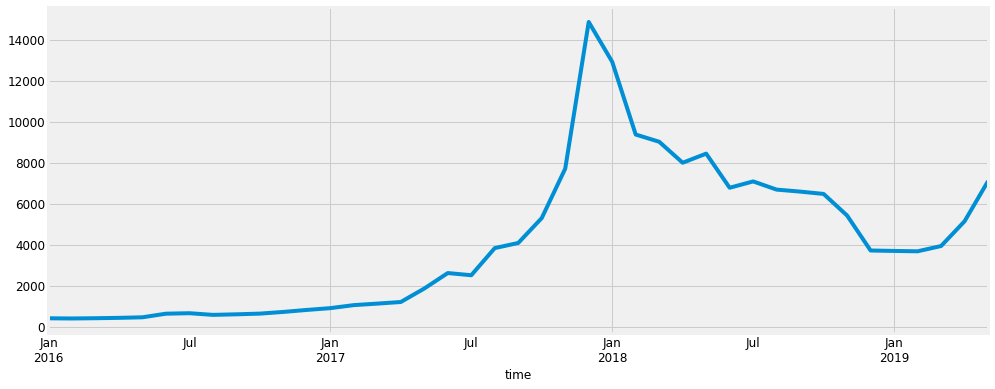

In [17]:
# Plotting the price over time i months.
month_hist.plot(figsize=(15,6))
plt.show()

---

# ARIMA prediction
ARIMA model is a statistical model for analyzing and forecasting time series data.

* Auto Regression tries to fit a line based on previous values. This is the 'p' in the ARIMA p-d-q formular. This value is setting how many months backwards we want to use to predict 1 month forward.

* Integrated makes the data stationary. This is the 'd' in the ARIMA p-d-q formular. The data must be stationary in order to work with it in the SARIMA model. Stationary is, the mean variance should be constant.

* Moving Average is the 'q' in the ARIMA p-d-q formular. It removes random movements and uses errors from previous time to predict current and future values.

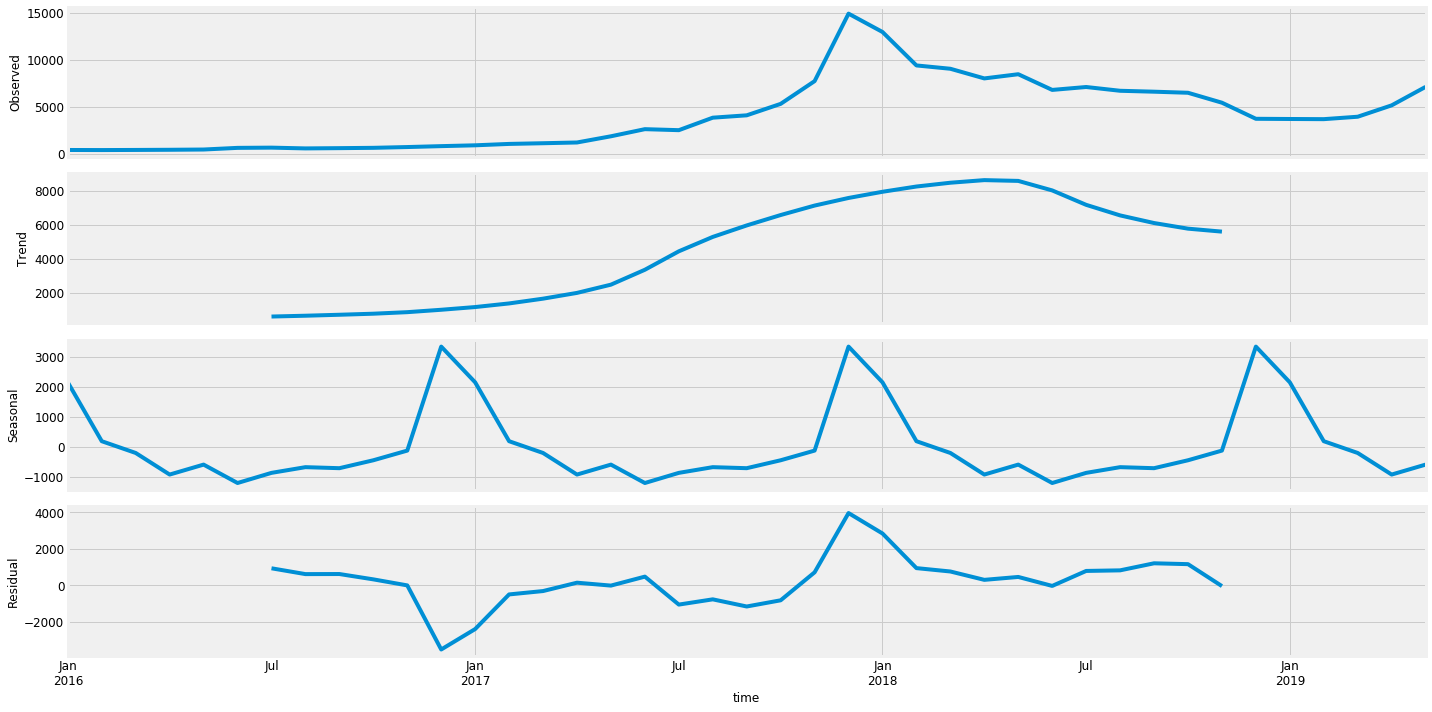

In [18]:
rcParams['figure.figsize'] = 20, 10

# Decomposing to visualize and identify trend, seasonality and residual.
# The graphs shows a opward going trend in the bitcoin market late 2016.
# There is a possible seasonality pattern at the end of the year with a big increase in price with a following decrease.
# Residual is noise. This is what there is left when removing trend and seasonal from the observed graph.
decomposition = sm.tsa.seasonal_decompose(month_hist, model='additive')
fig = decomposition.plot()
plt.show()

In [19]:
# ARIMA model (seasonal ARIMA, SARIMA)
# 'p' is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
# 'd' is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
# 'q' is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
# These are the three integers (p, d, q) that are used to parametrize ARIMA models.
p = d = q = range(0, 2)

# pdq is an array of tuples. 
# Generating 2 arrays of tuples with examples of parameter combinations bewtween (0-1).
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [20]:
# We are trying to find the combination with the lowest AIC(an estimator to realative quaility of statistical models for a given set of data).
for param in pdq:
    for param_seasonal in seasonal_pdq:
        # Try since not all combinations makes sense, some will throw an error.
        try:
            # Using Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model(SARIMAX).
            # eXogenous argument is not given, which makes it a SARIMA model.
            model = sm.tsa.statespace.SARIMAX(month_hist,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        # If we come across an invalid combination, just skip it and continue.
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:805.1859181916864
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:986.4113863537838
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:568.6390264096334
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:586.3326658910003


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1126.0216077968553
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:346.00989270109847
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:743.0161440705207
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:531.351580913868
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:558.4155607315777
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2235.594229226585
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:325.84264114266466
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:684.9061997058849
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:877.5023684387545
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:506.3150432852855
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:502.462905775247


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:487.1958937587322
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:274.7479083225138
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:668.2037276852287
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2075.6322514959893
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:488.76227686650844
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:502.98660147135286
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:470.70934910452627
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:274.95683464941095
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:703.2450639710698
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1220.2182571452104
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:524.5396547414839
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:506.06561474690375


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1347.5678062244335
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:271.5940214010443
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:686.2740704891625
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:440596568.145677
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:506.1920800170881
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:505.8776557519503
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2185.7654804762947
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:263.6275083898073
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:685.1819389380711
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1013.6393233537764
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:506.81157475082335


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:486.61320307335535
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:488.36172061685136
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:247.2840947617646
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:670.0626080633131
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2076.345696661325
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:490.6662525832451
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:487.6554916853118
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:472.5858894795634
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:248.4966198476736


In [22]:
# After trying our diffrent fits for our model, we pick the one with the lowest AIC.
# This what is supposed to make our model the most precise.
# Here we insert the order we find above.
model = sm.tsa.statespace.SARIMAX(month_hist,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary().tables[0])

                                 Statespace Model Results                                 
Dep. Variable:                     Weighted_Price   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -120.642
Date:                            Tue, 28 May 2019   AIC                            247.284
Time:                                    23:43:02   BIC                            249.408
Sample:                                01-01-2016   HQIC                           247.261
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         


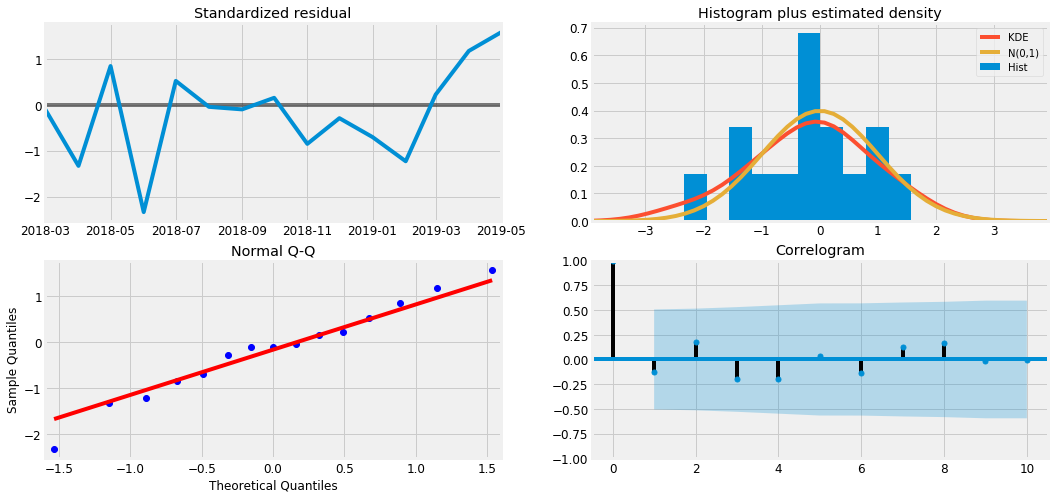

In [24]:
# Plotting model diagnostics to investigate unusual behavior.
# If the graph shows unusual behavior, it is a good sign of need for model improvement.

# Top-right shows a plot of standard notation for a normal distribution, N(0,1).
# Our model is indicated by the red line, KDE.
# This shows an overall normally distributed residuals.

# Bottom-left shows a plot of how residuals are distributed when following a trend. The red line shows a normal distribution.
# Blue dots idicate our model, which has very few outliers from the normal distribution.
# This is overall a pretty good result.

# Bottom-right shows a correlogram which plots the autocorrelation, which shows how residuals have correlation to lagged versions of itself.
# This result is not totally clear to us, so we can not draw any conclusion from it.
# However, it seems like there appear to be no correlation.

# Top-left shows residuals over time. In this case, 1 year and 2 months.
# The standardized residual seems to be white noise - it is hard to find any seasonality from the diagram.

results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Testing the model

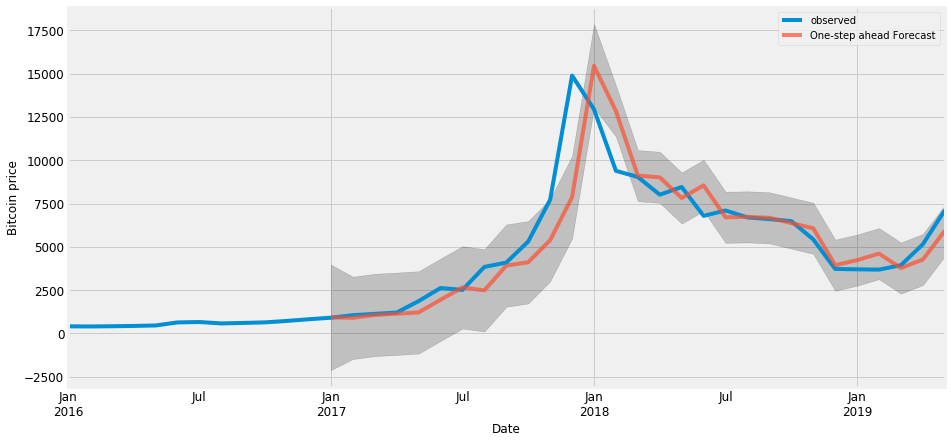

In [25]:
# Making a prediction from 1. Janurary 2017 to now, so we can compare the result with the actual observed graph.
pred = results.get_prediction(start=('2017-01-01'), dynamic=False)


# Plotting the observed graph and the 'one-step forecasting',
ax = month_hist.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts highst and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

In [26]:
# This is the confidence interval.
# It shows the difference between lower and upper values of predicted weighted price over time.
print(pred_ci)

            lower Weighted_Price  upper Weighted_Price
time                                                  
2017-01-01          -2112.253296           3976.896228
2017-02-01          -1479.261216           3277.082756
2017-03-01          -1311.057539           3442.766873
2017-04-01          -1240.836640           3512.985659
2017-05-01          -1162.967244           3590.855048
2017-06-01           -434.147911           4319.674381
2017-07-01            284.842960           5038.665252
2017-08-01            111.192676           4865.014968
2017-09-01           1539.396543           6293.218835
2017-10-01           1734.734859           6488.557150
2017-11-01           3010.712399           7764.534559
2017-12-01           5489.870674          10243.553035
2018-01-01          13045.655140          17867.591274
2018-02-01          11366.489931          14323.333937
2018-03-01           7639.009159          10590.123241
2018-04-01           7538.891487          10490.005569
2018-05-01

In [27]:
# Calculating the mean absolute error.
y_forecasted = pred.predicted_mean
y_truth = month_hist['2017-01-01':]

# Sklearn method takes the actual value and the predicted value as parameters.
# The mean absolute error is the mean difference between predicted and actual value
mae = mean_absolute_error(y_truth, y_forecasted)
print('Mean absolute error',mae)

Mean absolute error 982.5591385143393


## Future prediction

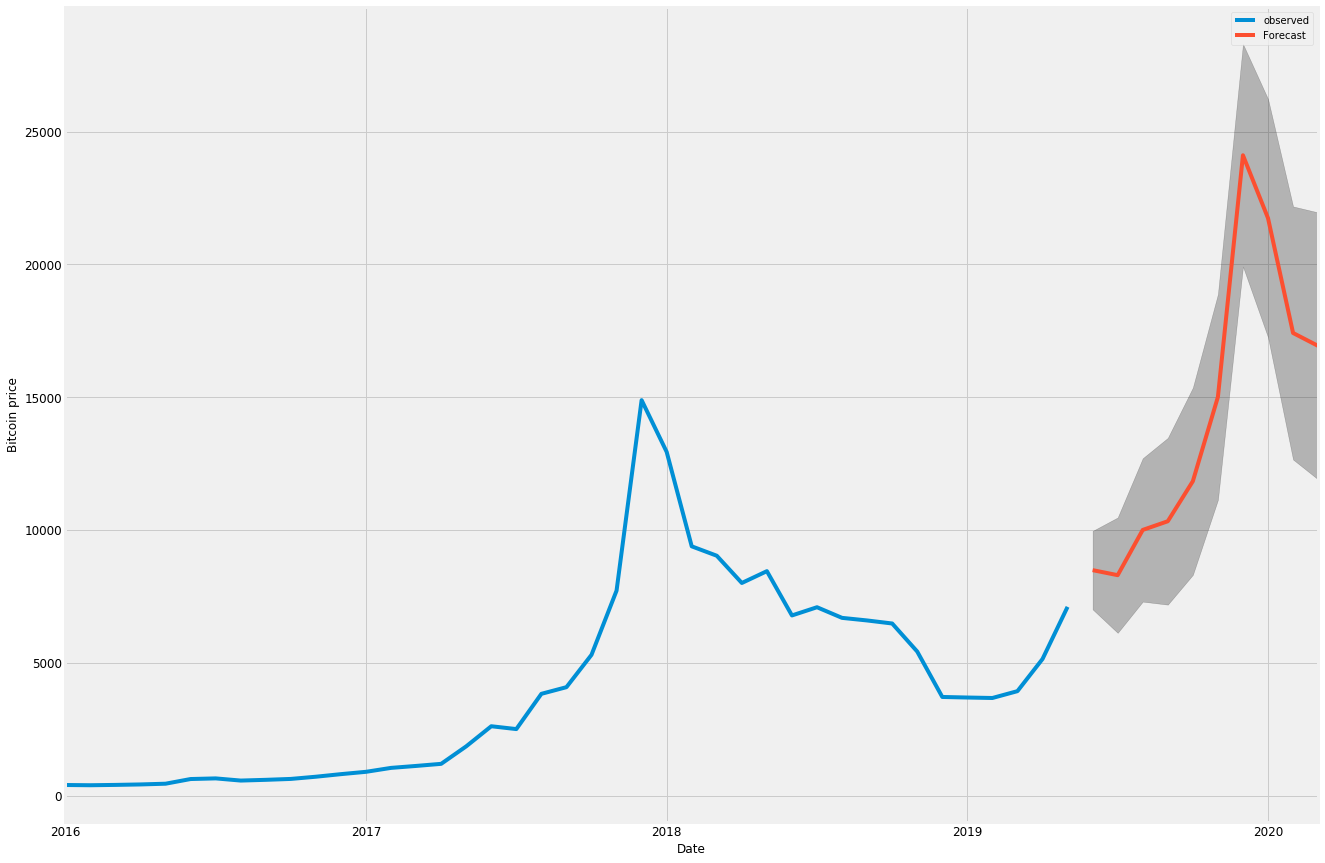

In [28]:
# We generate a forecast for the furture graph of Bitcoin.
# We call the method get_forecast which takes a parameter 'steps', as how many steps into the future do we want to forecast.
future_pred = results.get_forecast(steps=10)

# We plot the observed graph of Bitcoin prices.
ax = month_hist.plot(label='observed', figsize=(20, 15))
future_pred.predicted_mean.plot(ax=ax, label='Forecast')

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts higest and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = future_pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

In [29]:
# Plotting the result in USD
future_pred.predicted_mean

2019-06-01     8496.289795
2019-07-01     8306.690416
2019-08-01    10008.936421
2019-09-01    10335.456789
2019-10-01    11841.406153
2019-11-01    15010.714245
2019-12-01    24106.929175
2020-01-01    21740.639102
2020-02-01    17419.774819
2020-03-01    16932.809533
Freq: MS, dtype: float64

## Conclusion
The model does seem to capture the trends and seasonality in the Bitcoin price. However, this also means that in the future it will predict the price to rise dramatically, like it did at some point in the training set. It is difficult to tell whether or not the results are true, because they are predictions of the future.

---

# RNN LSTM Prediction
A **reccurent network** is networks with loops in them.
A loop allows information to be passed from on node in a network to another.
The image below illustrates a recurrent network. The loop to left is equal to the illustration of a loop on the right.
The network takes an input but also the output from the previous nodes as input to the current step.

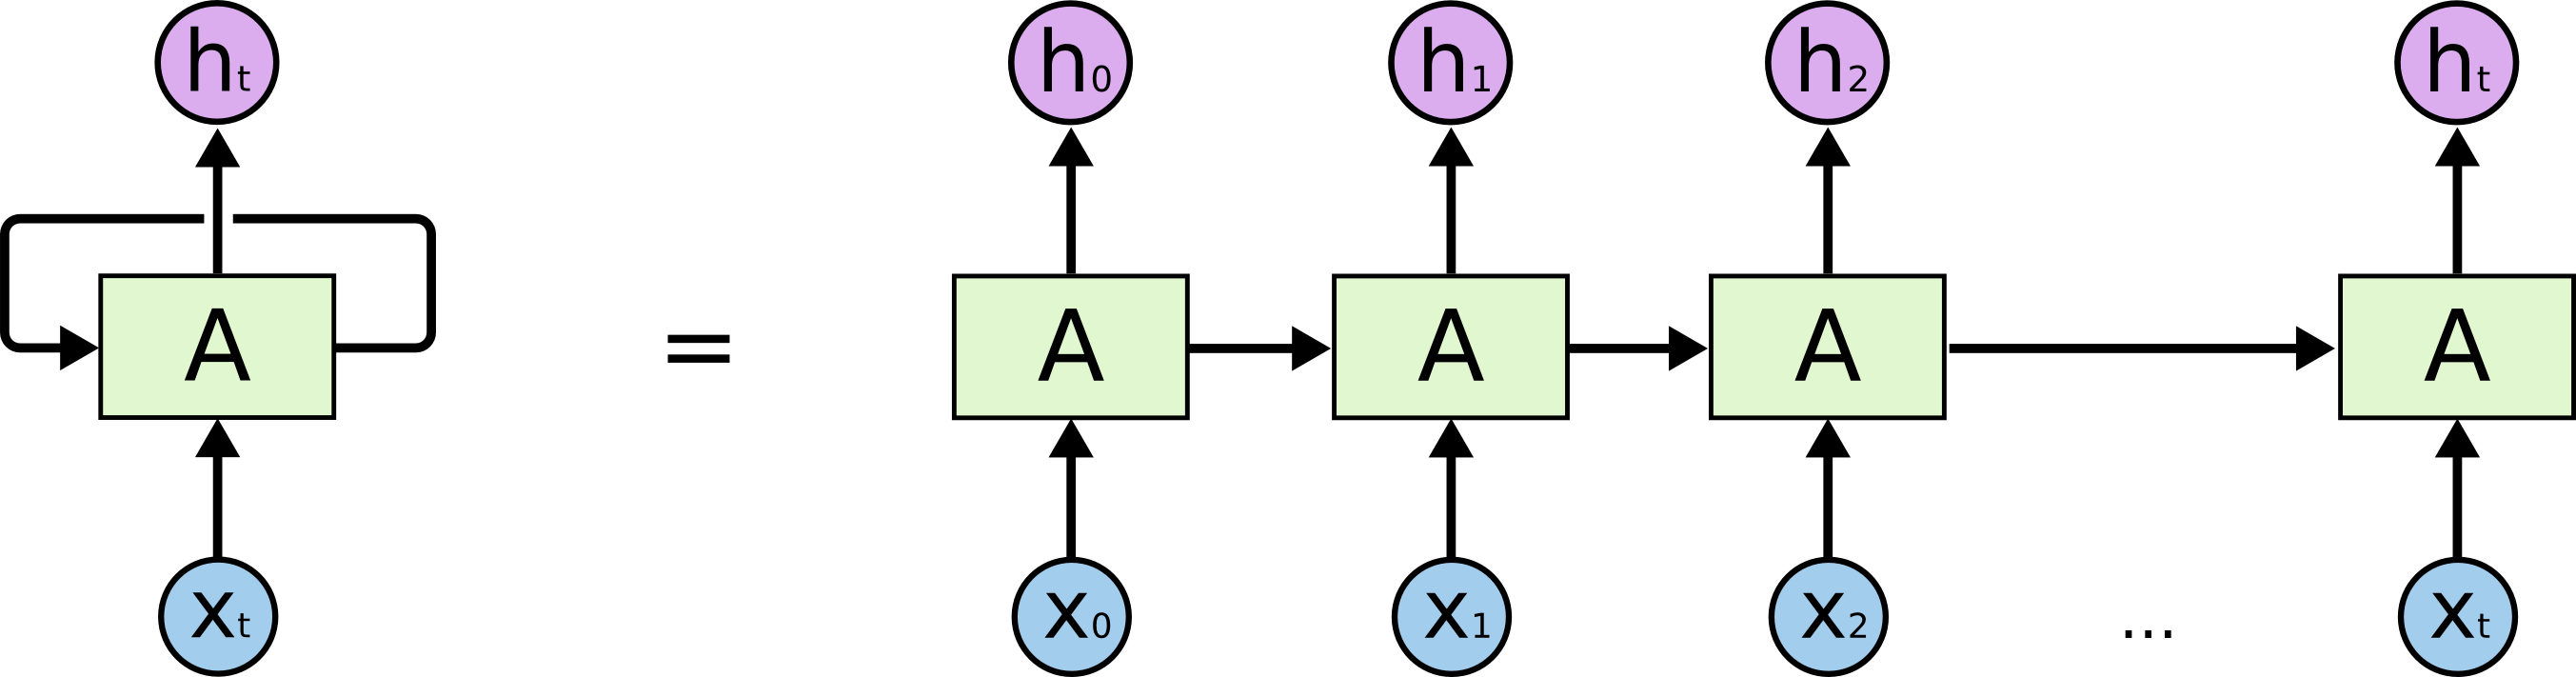


The idea behind the recurrent network is that it creates a kind of memory, which remembers all information about what has been calculated.

The **long-short term memory** comes into place as a hidden layer in the network. It's purpose is to enable RNN to remember inputs over a long period of time. The LSTM network has 3 gates. 
* Input gate, decides what is relevant to add from the current step.
* Forget gate, decides what is relevant to keep from prior steps and deletes information if it isn't important.
* Output gate, determines what the next hidden state should be.

With the above gates the model output the information to the next node & layer using Sigmoid and tanh layers.

In [30]:
# Reshaping numpy.ndarray from 1D array to 2D array
values = hist['Weighted_Price'].values.reshape(-1,1)
print(values[0])
# Converting the values to float.
values = values.astype('float32')
# Transform values to values between 0 and 1.
# This is the type of input LSTM takes.
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit to data, then transform it.
scaled = scaler.fit_transform(values)

# Get the length of the new item scaled
print("Length of the new datframe : " + str(len(scaled)))

# Get the first 5 elements from the scaled dataframe
print(scaled[0:5,])

[1113.4375]
Length of the new datframe : 2001
[[0.05196624]
 [0.04434619]
 [0.03316076]
 [0.03275506]
 [0.03938658]]


In [31]:
# Divide scaled data into 80% train and 40% test with overlapping.
train_size = int(len(scaled) * 0.8)
print("Train Size : " + str(train_size))

test_size = int(len(scaled) * 0.6)
print("Test Size : " + str(len(scaled) - test_size))

train, test = scaled[:train_size,:], scaled[test_size:len(scaled),:]
print("Length of training data : " + str(len(train)))
print("Length of testing data : " + str(len(test)))

Train Size : 1600
Test Size : 801
Length of training data : 1600
Length of testing data : 801


In [32]:
# Function for creating dataset with look back (y refers to previous x)
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # fx: 
        # 1st iteration - X:  [0.04680875] , Y:  0.051758032
        # 2nd iteration - X:  [0.05175803] , Y:  0.05387902
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [33]:
# Calling the create_dataset function with loop_back=1.
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1599, 1)
(1599,)
(800, 1)
(800,)


In [34]:
# Transform from 2D array to 3D array
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(1599, 1, 1)
(800, 1, 1)


In [35]:
# Initialise the sequential model
model = Sequential()

# Add the LSTM hidden layer with 128 nodes
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))

# Adding a dropout layer of 0.2 to prevent overfitting.
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(1))

# Compile the model with Mean Absolute Error as the loss factor and ADAM as the optimiser
model.compile(loss='mae', optimizer='adam')

# Fit the model using the training and testing data
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1599 samples, validate on 800 samples
Epoch 1/300
1599/1599 [==============================] - 1s 552us/step - loss: 0.0819 - val_loss: 0.2712
Epoch 2/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0803 - val_loss: 0.2628
Epoch 3/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0767 - val_loss: 0.2575
Epoch 4/300
1599/1599 [==============================] - 0s 50us/step - loss: 0.0721 - val_loss: 0.2423
Epoch 5/300
1599/1599 [==============================] - 0s 48us/step - loss: 0.0700 - val_loss: 0.2315
Epoch 6/300
1599/1599 [==============================] - 0s 44us/step - loss: 0.0665 - val_loss: 0.2203
Epoch 7/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0628 - val_lo

1599/1599 [==============================] - 0s 41us/step - loss: 0.0057 - val_loss: 0.0085
Epoch 70/300
1599/1599 [==============================] - 0s 44us/step - loss: 0.0062 - val_loss: 0.0097
Epoch 71/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0063 - val_loss: 0.0090
Epoch 72/300
1599/1599 [==============================] - 0s 39us/step - loss: 0.0083 - val_loss: 0.0090
Epoch 73/300
1599/1599 [==============================] - 0s 39us/step - loss: 0.0089 - val_loss: 0.0089
Epoch 74/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0071 - val_loss: 0.0109
Epoch 75/300
1599/1599 [==============================] - 0s 45us/step - loss: 0.0064 - val_loss: 0.0101
Epoch 76/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0068 - val_loss: 0.0094
Epoch 77/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0095 - val_loss: 0.0084
Epoch 78/300
1599/1599 [==============================] - 0s 43us/st

1599/1599 [==============================] - 0s 42us/step - loss: 0.0070 - val_loss: 0.0098
Epoch 147/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0085 - val_loss: 0.0100
Epoch 148/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0068 - val_loss: 0.0097
Epoch 149/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0061 - val_loss: 0.0093
Epoch 150/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0098 - val_loss: 0.0123
Epoch 151/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0061 - val_loss: 0.0087
Epoch 152/300
1599/1599 [==============================] - 0s 44us/step - loss: 0.0051 - val_loss: 0.0087
Epoch 153/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0055 - val_loss: 0.0089
Epoch 154/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0047 - val_loss: 0.0085
Epoch 155/300
1599/1599 [==============================] - 0

1599/1599 [==============================] - 0s 42us/step - loss: 0.0055 - val_loss: 0.0083
Epoch 224/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0050 - val_loss: 0.0083
Epoch 225/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0047 - val_loss: 0.0083
Epoch 226/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0048 - val_loss: 0.0084
Epoch 227/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0058 - val_loss: 0.0086
Epoch 228/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0057 - val_loss: 0.0089
Epoch 229/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0061 - val_loss: 0.0086
Epoch 230/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0046 - val_loss: 0.0086
Epoch 231/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0057 - val_loss: 0.0086
Epoch 232/300
1599/1599 [==============================] - 0

1599/1599 [==============================] - 0s 44us/step - loss: 0.0064 - val_loss: 0.0094


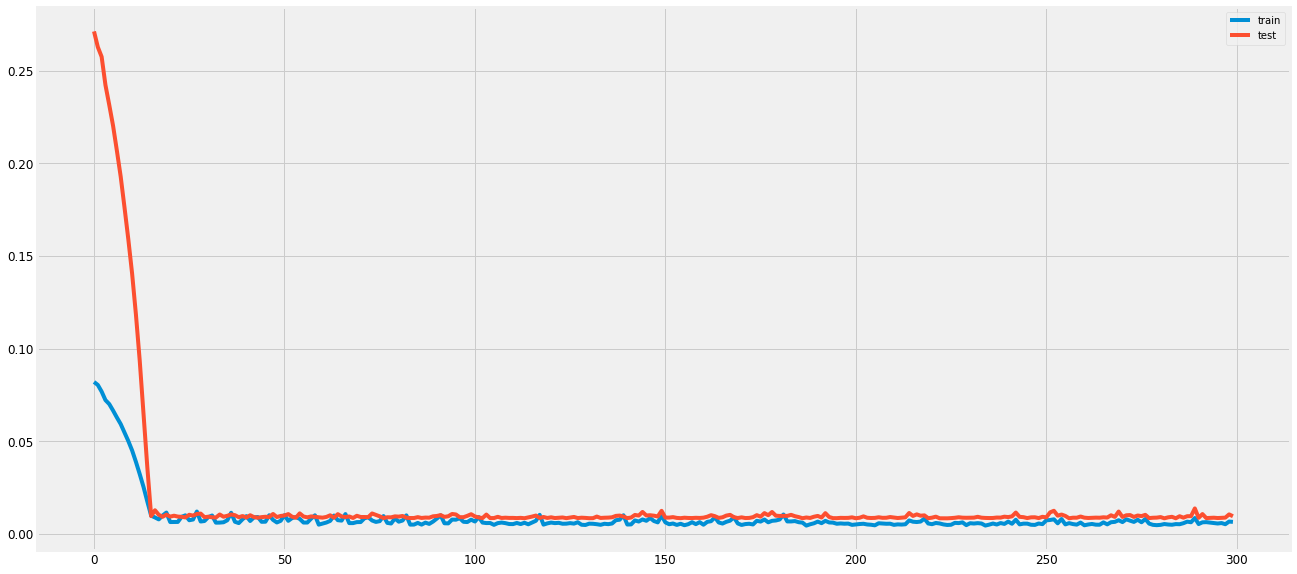

In [36]:
# Plotting the training loss vs the test validation loss.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

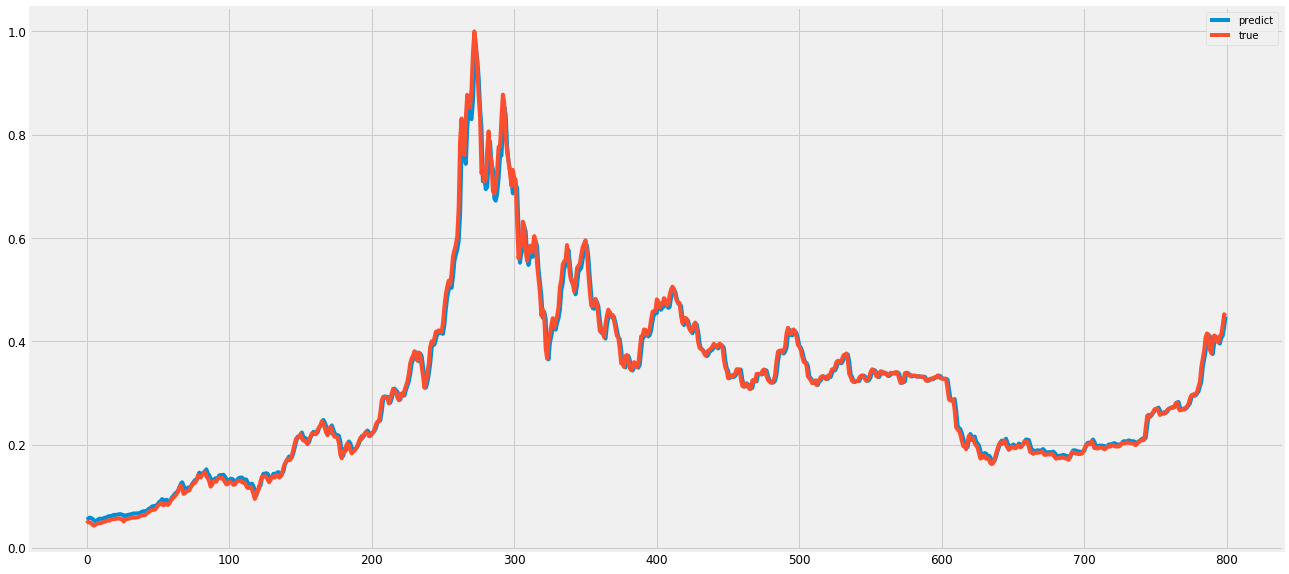

In [37]:
# We predict the values from testX.
yhat = model.predict(testX)

# Plotting the actual graph vs the predicted graph.
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

In [38]:
# scaler = MinMaxScaler(feature_range=(0, 1)) as used before for fit_transform and MinMaxScaler
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

print(yhat_inverse.shape)
print(testY_inverse.shape)

print(yhat_inverse[0])
print(testY_inverse[0])

(800, 1)
(800, 1)
[1169.2621]
[1033.165]


In [39]:
# Sklearn method takes the actual value and the predicted value as parameters.
# The mean absolute error is the mean difference between predicted and actual value
mae = mean_absolute_error(testY_inverse, yhat_inverse)
print('Mean absolute error',mae)

Mean absolute error 180.22182


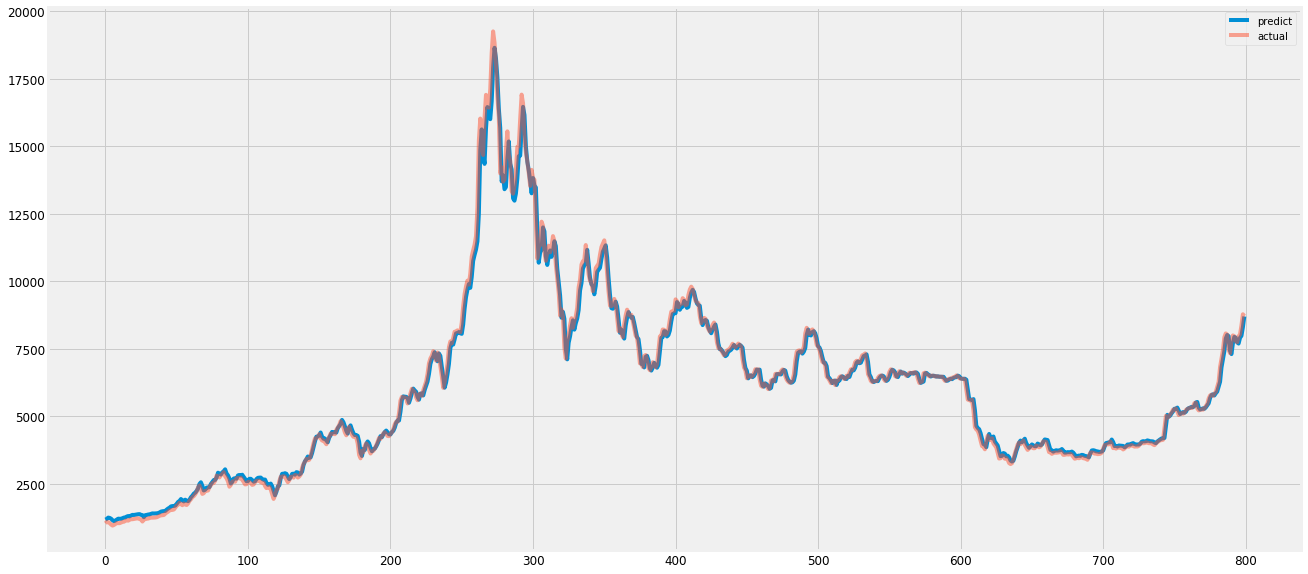

In [40]:
# Plotting prediction vs actual graph.
# This plotting shows the price.
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

In [41]:
# Creating a new variable containing the testX values.
# Just for good measure.
Xtest = testX

# Predicting the values from Xtest and appending the last preicted value
# to the set before predicting again
for i in range(30):
    future_preds = model.predict(Xtest) # Here yhat is the predicted value from the test set (y_pred)
    
    y = np.zeros((1,1,1))
    y[[0]] = future_preds[len(future_preds)-1][0]
    
    Xtest = np.append(Xtest, y, axis=0)

In [42]:
future_preds_inverse = scaler.inverse_transform(future_preds.reshape(-1, 1))

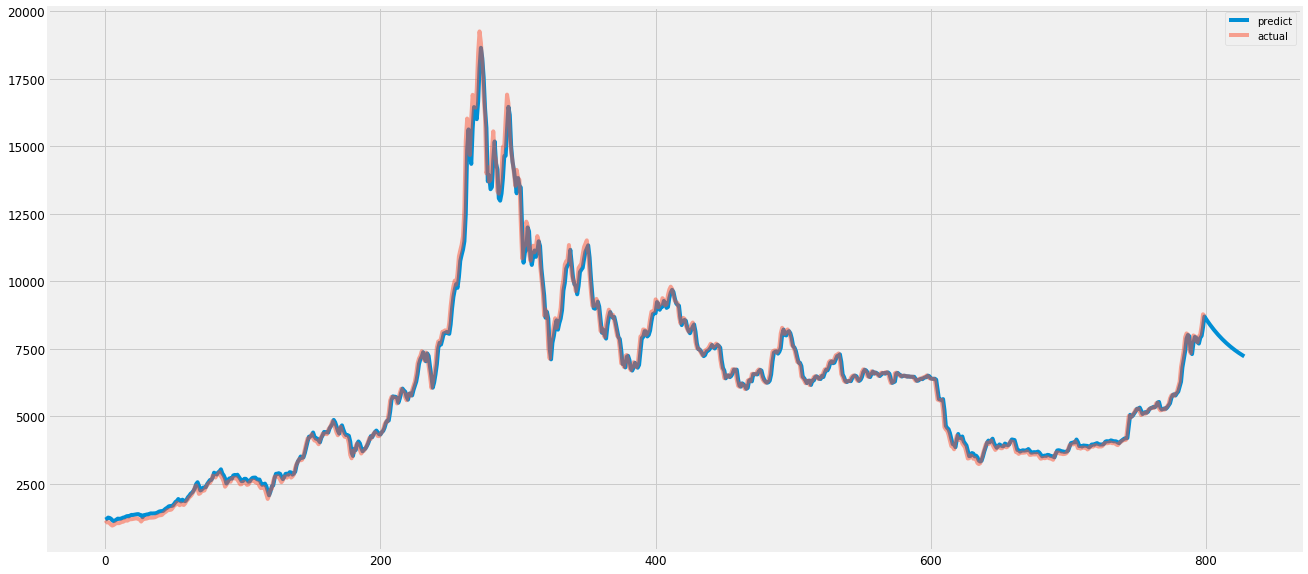

In [43]:
plt.plot(future_preds_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)

plt.legend()
plt.show()

# Refferences
* https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/ (28/05/2019)
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/ (28/05/2019)
* https://towardsdatascience.com/recurrent-neural-networks-and-lstm-4b601dd822a5 (28/05/2019)
* https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/ (28/05/2019)
* https://medium.com/fintechexplained/understanding-auto-regressive-model-arima-4bd463b7a1bb (28/05/2019)
* https://towardsdatascience.com/arima-sarima-vs-lstm-with-ensemble-learning-insights-for-time-series-data-509a5d87f20a (28/05/2019)

# Conclusion

By looking at the the plotted predictions compared to the actual values, and by looking at the mean absoluted error (MAE), it is very clear, that the best model on paper is our RNN LSTM model. The MAE of the SARIMA model is significantly higher than the one of the RNN LSTM model. However, the RNN LSTM model seems to have a random behaviour when predicting future values, which suggests the model is overfitted.

With this in mind we will save the SARIMA model for future predictions:

In [44]:
# Saving the model
results.save('SARIMA_btc_pred.pkl')

# Web app for predicting future prices

At last we create a wep app for predicting future prices of Bitcoins based on number of months.

In [45]:
%%writefile aiwebflask.py

# Import libraries
import numpy as np
from sklearn.externals import joblib
from flask import Flask, request, jsonify, render_template
import pickle

# create an instance (our app)
app = Flask(__name__)

results = joblib.load('SARIMA_btc_pred.pkl')

@app.route('/', methods=['GET', 'POST'])
def predict():
    return render_template('prediction.html')

@app.route('/predicted', methods=['GET', 'POST'])
def predicted():
    if request.method == 'POST':
        months = int(request.form['months'])
        predicted = results.get_forecast(steps=months).predicted_mean
        
        predicted = predicted[len(predicted)-1]

        return render_template("predicted.html", months=months, prediction=predicted)

@app.route('/bye')
def bye():
    return render_template('bye.html')

if __name__ == '__main__':
    app.run(debug=True)

Overwriting aiwebflask.py


In [11]:
!python aiwebflask.py

 * Serving Flask app "aiwebflask" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 127-720-728
127.0.0.1 - - [28/May/2019 23:31:41] "GET / HTTP/1.1" 200 -
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
127.0.0.1 - - [28/May/2019 23:31:46] "POST /predicted HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2019 23:31:48] "GET /?submit=make+another+prediction HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2019 23:31:52] "POST /predicted HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2019 23:31:53] "GET /?submit=make+another+prediction HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2019 23:31:57] "POST /predicted HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2

# Final conclusion

Both of these models are based on the assumption that future predictions of time series data is based on the past. This might make more sense when looking into sales or stock price where seasonal fluctuations are not as big. The RNN LSTM model is very well fittet and it might give good short term predictions, while the ARIMA model seems to provide better long term predictions.

At last we can conclude that it is theoretically possible to predict Bitcoin prices based on time series data. However, the huge seasonal flunctuations makes it very difficult for the models to find a pattern. With that in mind you might consider using other methods than time series predictions like classification models based on datasets containing data like Google searches or website traffic.